# Image Denoising

## Importing Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices()[2], True)
from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, UpSampling2D, merge
from keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU, ReLU, Input, Conv2DTranspose
import os
from tqdm import tqdm
import keras
from keras.callbacks import EarlyStopping
import cv2
from sklearn.model_selection import train_test_split
from skimage.io import imshow, imsave, imread
from skimage.color import lab2rgb, rgb2lab, gray2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
data_dir = r'D:\Datasets\denoise' 
img_size = 256

## Loading Images

In [3]:
data = []
for image in tqdm(os.listdir(data_dir)):
    img = imread(data_dir + '\\' + image)
    img = resize(img, (img_size, img_size))
    data.append(img)
data = np.array(data)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:30<00:00, 33.20it/s]


In [4]:
X_train, X_test, _, _ = train_test_split(data, data, train_size = 0.20, random_state = 69)

In [5]:
print(X_train.shape, X_test.shape)

(600, 256, 256, 3) (2400, 256, 256, 3)


## Adding Artificial Noise to the Images

In [6]:
noise_factor = 0.15 # Artificial Noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0, scale=1, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0, scale=1, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.) #Clipping the values
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

print( X_train_noisy.shape, X_test_noisy.shape)

(600, 256, 256, 3) (2400, 256, 256, 3)


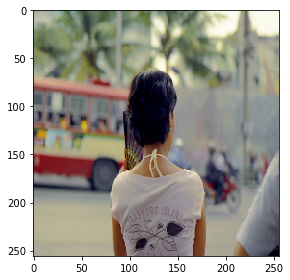

In [7]:
imshow(X_train[12]) #Original Image
plt.show()

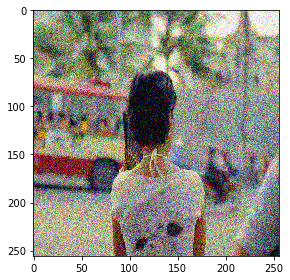

In [8]:
imshow(X_train_noisy[12]) #Noisy Image
plt.show()

## Auto Encoder

In [38]:
denoise = Sequential()

############################## Encoding ###################################### 

denoise.add(Conv2D(16, (3, 3), padding='same', input_shape = (img_size, img_size, 3)))
denoise.add(LeakyReLU())
denoise.add(MaxPooling2D((2, 2), padding='same'))
          
denoise.add(Conv2D(8, (3, 3), padding='same'))
denoise.add(LeakyReLU())
denoise.add(MaxPooling2D((2, 2), padding='same'))

################################ Decoding #####################################

denoise.add(Conv2D(8, (3, 3), padding='same'))
denoise.add(LeakyReLU())
denoise.add(UpSampling2D((2, 2)))

denoise.add(Conv2D(16, (3, 3), padding='same'))
denoise.add(LeakyReLU())
denoise.add(UpSampling2D((2, 2)))

denoise.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
          
denoise.summary()
denoise.compile(optimizer='adam', loss='mse')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 8)        

## Training Model

In [39]:
early = EarlyStopping(restore_best_weights =  True, patience = 2)

denoise.fit(X_train_noisy, X_train, epochs = 500, batch_size = 32, shuffle = True, 
          validation_data = (X_test_noisy, X_test), callbacks = early)

Epoch 1/500
19/19 [==============================] - 9s 455ms/step - loss: 0.0698 - val_loss: 0.0454
Epoch 2/500
19/19 [==============================] - 7s 389ms/step - loss: 0.0296 - val_loss: 0.0217
Epoch 3/500
19/19 [==============================] - 8s 397ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 4/500
19/19 [==============================] - 7s 384ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 5/500
19/19 [==============================] - 7s 380ms/step - loss: 0.0142 - val_loss: 0.0125
Epoch 6/500
19/19 [==============================] - 7s 365ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/500
19/19 [==============================] - 7s 371ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 8/500
19/19 [==============================] - 7s 379ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 9/500
19/19 [==============================] - 7s 372ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 10/500
19/19 [==============================] - 7s 379ms/step - loss: 0.0094 - val_lo

## Model Evaluating

In [12]:
denoise.evaluate(X_test_noisy, X_test)

75/75 [==============================] - 11s 149ms/step - loss: 0.0139


0.013900144957005978

## Model Prediction

In [ ]:
no_noise_img = denoise.predict(X_test_noisy[300].reshape(1, img_size, img_size, 3))

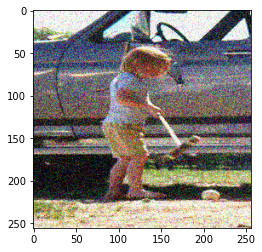

In [41]:
plt.imshow(X_test_noisy[300].reshape(img_size, img_size, 3))
plt.show()

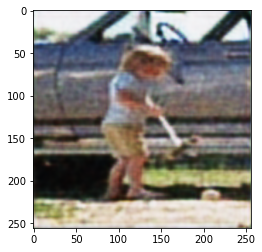

In [42]:
plt.imshow(no_noise_img.reshape(img_size, img_size, 3))
plt.show()

## Conclusion -
- Model can be improved by using more Deep Nural Networks(if one have resources at disposal).
- Incresing Dataset size can be benefical.